# MultiScaleSimFull

## Overview
This notebook simulates and analyzes how different image augmentations affect model performance using CLIP and SWIN backbones. It focuses on evaluating how image transformations impact synthetic outcomes through cross-resolution learning.

## Key Components
1. **Setup**: Imports required libraries and sets global variables
2. **Data Processing**: Loads and preprocesses image data
3. **Augmentations**: Implements image transformations:
   - Black blob addition
   - Edge fading
   - Contrast adjustment
4. **Model**: Uses MLP for prediction tasks
5. **Experimentation**: Runs K-fold cross-validation across different augmentation combinations
6. **Results**: Saves performance metrics to CSV

The notebook also visualizes the augmentations with privatized data and stores it in `Augmentation_Vis.png`.

In [1]:
import os
# Set your working directory
wd = "/n/holylabs/LABS/meng_lab/Lab/Sim/"
os.chdir(wd)
import sys
import copy
import logging 
import time
import random
from PIL import Image, ImageDraw, ImageFilter, ImageOps, ImageEnhance
from collections import defaultdict
from Utils import process_images
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
from transformers import CLIPModel, CLIPProcessor, AutoImageProcessor, SwinModel, set_seed
from torchvision import transforms
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from scipy import stats

# Global Variables
MODEL_TYPE = 'CLIP' # 'CLIP', 'SWIN', 
CLIP=True
SWIN=!CLIP

assert CLIP != SWIN
REDOWNLOADDATA = False
monte_carlo_i = 1
Separate = False
Full=True
target_name = 'NOTobsY' # 'obsY', or 'tauPred'
image_sizes = [32, 256]
NUM_IMAGE_SIZES = len(image_sizes)

# Path parameters
optimize_image_reps = "clip-rsicd"
data_type = "image"
perturbation_type = "DHS"
applications = ["peru"]
perturbation_magnitude = 0
image_type = "original"
# For privacy preserving visualisation
if False:
    perturbation_type = "deterministic"
    applications = ["peru"]
    perturbation_magnitude = 10
    image_type = "cluster"
    
if sys.argv[1] == '-f':
    iter_num = -1
    print("Warning: Running in Jupyter Notebook. Using default value -1.")
elif len(sys.argv) > 1:
    args = sys.argv[1:]  # Get command line arguments
    iter_num = int(args[0])  # Assuming args is defined earlier in the code
    monte_carlo_i = int(args[1])
    if len(sys.argv) > 3:
        image_size1 = args[2]
        image_size2 = args[3]
else:
    iter_num = -1
    print("Warning: No iteration number provided. Using default value -1.")

# Directories
os.makedirs('./Figures', exist_ok=True)
os.makedirs('./TrainingInfo', exist_ok=True)
os.makedirs('./log', exist_ok=True)
os.makedirs('./FineTuneIterResults', exist_ok=True)
save_ImageTensor_dir = './DataInfo/Images'
saveObsWDir = './DataInfo/ObsW'
saveGeoDir = './DataInfo/geo'
saveObsYDir = './DataInfo/ObsY'
saveTrainIndicesDir = './DataInfo/TrainIndices'
saveResDir = './FineTuneIterResults/FineTuneRes'
saveRepDir = './FineTuneIterResults/FineTuneReps'

saveDirs = [saveObsWDir, saveGeoDir, saveObsYDir, save_ImageTensor_dir, saveTrainIndicesDir, saveResDir, saveResDir]
for dir in saveDirs:
    os.makedirs(dir, exist_ok=True)
    os.makedirs(dir, exist_ok=True)
logging.basicConfig(filename=f'./log/trainingIter_{iter_num}.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
    
def set_all_seeds(seed_value=42):
    # 1. Python's built-in random library
    random.seed(seed_value)
    
    # 2. NumPy's random seed
    np.random.seed(seed_value)
    
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
set_all_seeds(monte_carlo_i)

# Conditional loading of models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if CLIP:
    # Load CLIP model and processor
    backbone_model = CLIPModel.from_pretrained("flax-community/clip-rsicd-v2").to(device)
    backbone_processor = CLIPProcessor.from_pretrained("flax-community/clip-rsicd-v2")
    print("Running CLIP")

elif SWIN:
    # Load Swin model and processor
    backbone_processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
    backbone_model = SwinModel.from_pretrained("microsoft/swin-tiny-patch4-window7-224").to(device)
    print("Running SWIN")

else:
    # Raise an error if neither model is selected
    raise ValueError("You need to specify a valid backbone model: CLIP or SWIN.")
#from transformers import ViTMAEModel, AutoImageProcessor
#backbone_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base")
#backbone_model = ViTMAEModel.from_pretrained("facebook/vit-mae-base")

2024-10-30 16:41:27.163991: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 16:41:27.175893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 16:41:27.191352: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 16:41:27.195872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 16:41:27.207289: I tensorflow/core/platform/cpu_feature_guar

Running CLIP


# Get Data

In [2]:
# Initialize lists and dictionaries
pil_images = []
targets = []
application_len = {}
application_image_ids = {}
ObsW = {}
ObsY = {}
geo = {}
results_list = []
pil_images_list = []
for application in applications:
    for image_size in image_sizes:
        # Define image directory with a single image size
        image_size = image_size
        # Get image directory path
        image_dir = f'/n/holylabs/LABS/meng_lab/Lab/IndividIm/Data/{application}/monte_carlo_{monte_carlo_i}/satellite_images/landsat/{perturbation_type}/{image_size}/30/{image_type}_{application}/magnitude_{perturbation_magnitude}/'
        my_data_path = "/n/holylabs/LABS/meng_lab/Lab/IndividIm/Data/Joint/pooled_hh.dta"
        geo_path = f"/n/holylabs/LABS/meng_lab/Lab/IndividIm/Data/{application}/master/gps_locations/{application}_cluster_center_coordinates_per_person_fully_subsetted.csv"
        results_path = f"/n/holylabs/LABS/meng_lab/Lab/IndividIm/SavedResults/{application}/monte_carlo_{monte_carlo_i}/{optimize_image_reps}/landsat/DHS/{image_size}/30/asset_hh_index_diff/rs_nDepthIS1_analysisTypeISheterogeneity_imageModelClassISVisionTransformer_optimizeImageRepIS{optimize_image_reps}_dataTypeISimage_applicationIS{application}_perturbationMagnitudeIS{perturbation_magnitude}_monte_carlo_iIS{monte_carlo_i}_original_10.csv"

        # Load and preprocess data
        geo_df = pd.read_csv(geo_path)
        my_data = pd.read_stata(my_data_path)  
        new_columns = pd.DataFrame({
            'obsY': my_data['asset_hh_index_end'] - my_data['asset_hh_index_bsl'],
            'treatment_indicator': my_data['treatment'].map({'Control': 0, 'Treatment': 1}),
        })
        my_data = pd.concat([my_data, new_columns], axis=1)
        my_data = my_data[my_data['id'].astype(str).isin(geo_df['FPrimary'].astype(str))]
        my_data = my_data[my_data['obsY'].notna()].reset_index(drop=True)

        if len(my_data) % 2 != 0: 
            my_data = my_data.iloc[:-1]

        total_size = len(my_data)
        application_len[application] = total_size

        # Assign all indices for processing without train-test split
        all_indices = list(my_data.index)

        # Load outcome targets
        results_df = pd.read_csv(results_path)
        new_targets = results_df['tau_est'].values
        targets.extend(list(new_targets[all_indices]))

        id_with_outcome = my_data['id'].astype(str).values
        assert (len(id_with_outcome) % 2) == 0, "ID count is not even."

        # Function to extract ID from filename
        def extract_id(filename):
            return filename.split("-")[0]

        # Get sorted list of image paths based on IDs
        subsetted_image_paths = [file for file in os.listdir(image_dir) if extract_id(file) in id_with_outcome]

        # Create a mapping from ID to filename
        id_to_filename = {extract_id(file): file for file in subsetted_image_paths}

        # Ensure all IDs have corresponding images
        missing_ids = set(id_with_outcome) - set(id_to_filename.keys())

        if missing_ids:
            raise ValueError(f"Missing images in image_dir for IDs: {missing_ids}")

        # Process images in the order of id_with_outcome
        pil_images_app = process_images(image_dir, [id_to_filename[id] for id in id_with_outcome])
        pil_images.extend(pil_images_app)
        application_image_ids[(application, image_size)] = list(my_data['id'].astype(str))

        # Get auxiliary info for regression
        ObsW[(application, image_size)] = my_data['treatment_indicator']
        ObsY[(application, image_size)] = my_data['obsY']
        geo[(application, image_size)] = my_data['geo']
        pil_images_list.append(pil_images_app)
        results_list.append(results_df)

Processed 1392 images from /n/holylabs/LABS/meng_lab/Lab/IndividIm/Data/peru/monte_carlo_1/satellite_images/landsat/DHS/32/30/original_peru/magnitude_0/
Processed 1392 images from /n/holylabs/LABS/meng_lab/Lab/IndividIm/Data/peru/monte_carlo_1/satellite_images/landsat/DHS/256/30/original_peru/magnitude_0/


# Below is for Getting the Cluster Images for Privacy-Preserving Visualizations

In [15]:
# For privacy preserving visualisation
if True:
    perturbation_type = "deterministic"
    applications = ["peru"]
    perturbation_magnitude = 10
    image_type = "cluster"

# Initialize lists and dictionaries
pil_images = []
targets = []
application_len = {}
application_image_ids = {}
ObsW = {}
ObsY = {}
geo = {}
results_list = []
pil_images_list = []
for application in applications:
    for image_size in image_sizes:
        # Define image directory with a single image size
        image_size = image_size
        image_dir = f'./Data/{application}/monte_carlo_{monte_carlo_i}/satellite_images/landsat/{perturbation_type}/{image_size}/30/{image_type}_{application}/magnitude_{perturbation_magnitude}/'
        my_data_path = "./Data/Joint/pooled_hh.dta"
        geo_path = f"./Data/{application}/master/gps_locations/{application}_cluster_center_coordinates_per_person_fully_subsetted.csv"
        results_path = f"./SavedResults/{application}/monte_carlo_{monte_carlo_i}/{optimize_image_reps}/landsat/DHS/{image_size}/30/asset_hh_index_diff/rs_nDepthIS1_analysisTypeISheterogeneity_imageModelClassISVisionTransformer_optimizeImageRepIS{optimize_image_reps}_dataTypeISimage_applicationIS{application}_perturbationMagnitudeIS{perturbation_magnitude}_monte_carlo_iIS{monte_carlo_i}_original_10.csv"

        # Load and preprocess data
        geo_df = pd.read_csv(geo_path)
        my_data = pd.read_stata(my_data_path)  

        # Get sorted list of image paths based on IDs
        subsetted_image_paths = [file for file in os.listdir(image_dir)]

        # Process images in the order of id_with_outcome
        pil_images_app = process_images(image_dir, subsetted_image_paths)
        pil_images.extend(pil_images_app)
        application_image_ids[(application, image_size)] = list(my_data['id'].astype(str))

        # Get auxiliary info for regression
        pil_images_list.append(pil_images_app)


Processed 100 images from /n/holylabs/LABS/meng_lab/Lab/IndividIm/Data/peru/monte_carlo_1/satellite_images/landsat/deterministic/32/30/cluster_peru/magnitude_10/
Processed 100 images from /n/holylabs/LABS/meng_lab/Lab/IndividIm/Data/peru/monte_carlo_1/satellite_images/landsat/deterministic/256/30/cluster_peru/magnitude_10/


# Define Image Augmentation Functions

In [3]:
def add_black_blob(image, blob_size=2):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    width, height = image.size
    center = (width // 2, height // 2)
    top_left = (center[0] - blob_size, center[1] - blob_size)
    bottom_right = (center[0] + blob_size, center[1] + blob_size)
    draw.rectangle([top_left, bottom_right], fill='black')
    return image

def add_edge_fade(image, fade_color=(0, 0, 0), fade_size=30):
    # Convert the image to grayscale to create a radial gradient mask
    width, height = image.size
    x = np.linspace(-1, 1, width)
    y = np.linspace(-1, 1, height)
    xx, yy = np.meshgrid(x, y)
    distance = np.sqrt(xx**2 + yy**2)

    # Create a radial fade mask (distance scaled to fade_size)
    mask = np.clip(1 - distance * fade_size, 0, 1)
    mask = (mask * 255).astype(np.uint8)

    # Convert the grayscale mask to an image
    mask_image = Image.fromarray(mask)

    # Create a solid image with the fade color
    fade_image = Image.new("RGB", (width, height), fade_color)

    # Composite the original image and the fade image using the mask
    faded_image = Image.composite(image, fade_image, mask_image)

    return faded_image

# Function to adjust the contrast of an image
def adjust_contrast(image, contrast_factor=1.2):
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(contrast_factor)

# Define a simple MLP model (as in your original code)
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)
    
# Helper function to calculate confidence intervals
def mean_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard Error of the Mean
    margin = sem * stats.t.ppf((1 + confidence) / 2., n-1)
    return mean, margin

# Implement Loop

In [10]:
import pandas as pd
from itertools import product

# Define variables and their possible values
variables = ['ROTATION', 'BLOB', 'CONTRAST', 'EDGE']
values = [0, 1]

# Generate all possible combinations
combinations = list(product(values, repeat=len(variables)))

# Create a list to store results
results = []

# Create readable index names
index_names = []

for combo in combinations:
    # Create a dictionary mapping variables to their values
    params = dict(zip(variables, combo))
    
    # Create readable index name
    index_name = '_'.join([f"{var[:3]}{val}" for var, val in params.items()])
    
    # Here you would run your actual experiment
    # For demonstration, we'll use placeholder values
    experiment_results = {
        'cr_mean': 0.0,  # Replace with actual experiment results
        'normal_32_mean': 0.0,
        'normal_256_mean': 0.0,
        'cr_margin': 0.0,
        'normal_32_margin': 0.0,
        'normal_256_margin': 0.0
    }
    
    # Add experiment parameters to results
    result_row = {**params, **experiment_results}
    results.append(result_row)
    index_names.append(index_name)

# Create DataFrame
df = pd.DataFrame(results, index=index_names)

# Reorder columns to have parameters first, then results
param_cols = variables
result_cols = ['cr_mean', 'normal_32_mean', 'normal_256_mean', 
               'cr_margin', 'normal_32_margin', 'normal_256_margin']
df = df[param_cols + result_cols]

# Display the first few rows
print("\nDataFrame Preview:")
print(df.head())

# Save to CSV if needed
# df.to_csv('experiment_results.csv')


DataFrame Preview:
                     ROTATION  BLOB  CONTRAST  EDGE  cr_mean  normal_32_mean  \
ROT0_BLO0_CON0_EDG0         0     0         0     0      0.0             0.0   
ROT0_BLO0_CON0_EDG1         0     0         0     1      0.0             0.0   
ROT0_BLO0_CON1_EDG0         0     0         1     0      0.0             0.0   
ROT0_BLO0_CON1_EDG1         0     0         1     1      0.0             0.0   
ROT0_BLO1_CON0_EDG0         0     1         0     0      0.0             0.0   

                     normal_256_mean  cr_margin  normal_32_margin  \
ROT0_BLO0_CON0_EDG0              0.0        0.0               0.0   
ROT0_BLO0_CON0_EDG1              0.0        0.0               0.0   
ROT0_BLO0_CON1_EDG0              0.0        0.0               0.0   
ROT0_BLO0_CON1_EDG1              0.0        0.0               0.0   
ROT0_BLO1_CON0_EDG0              0.0        0.0               0.0   

                     normal_256_margin  
ROT0_BLO0_CON0_EDG0                0.0  
RO

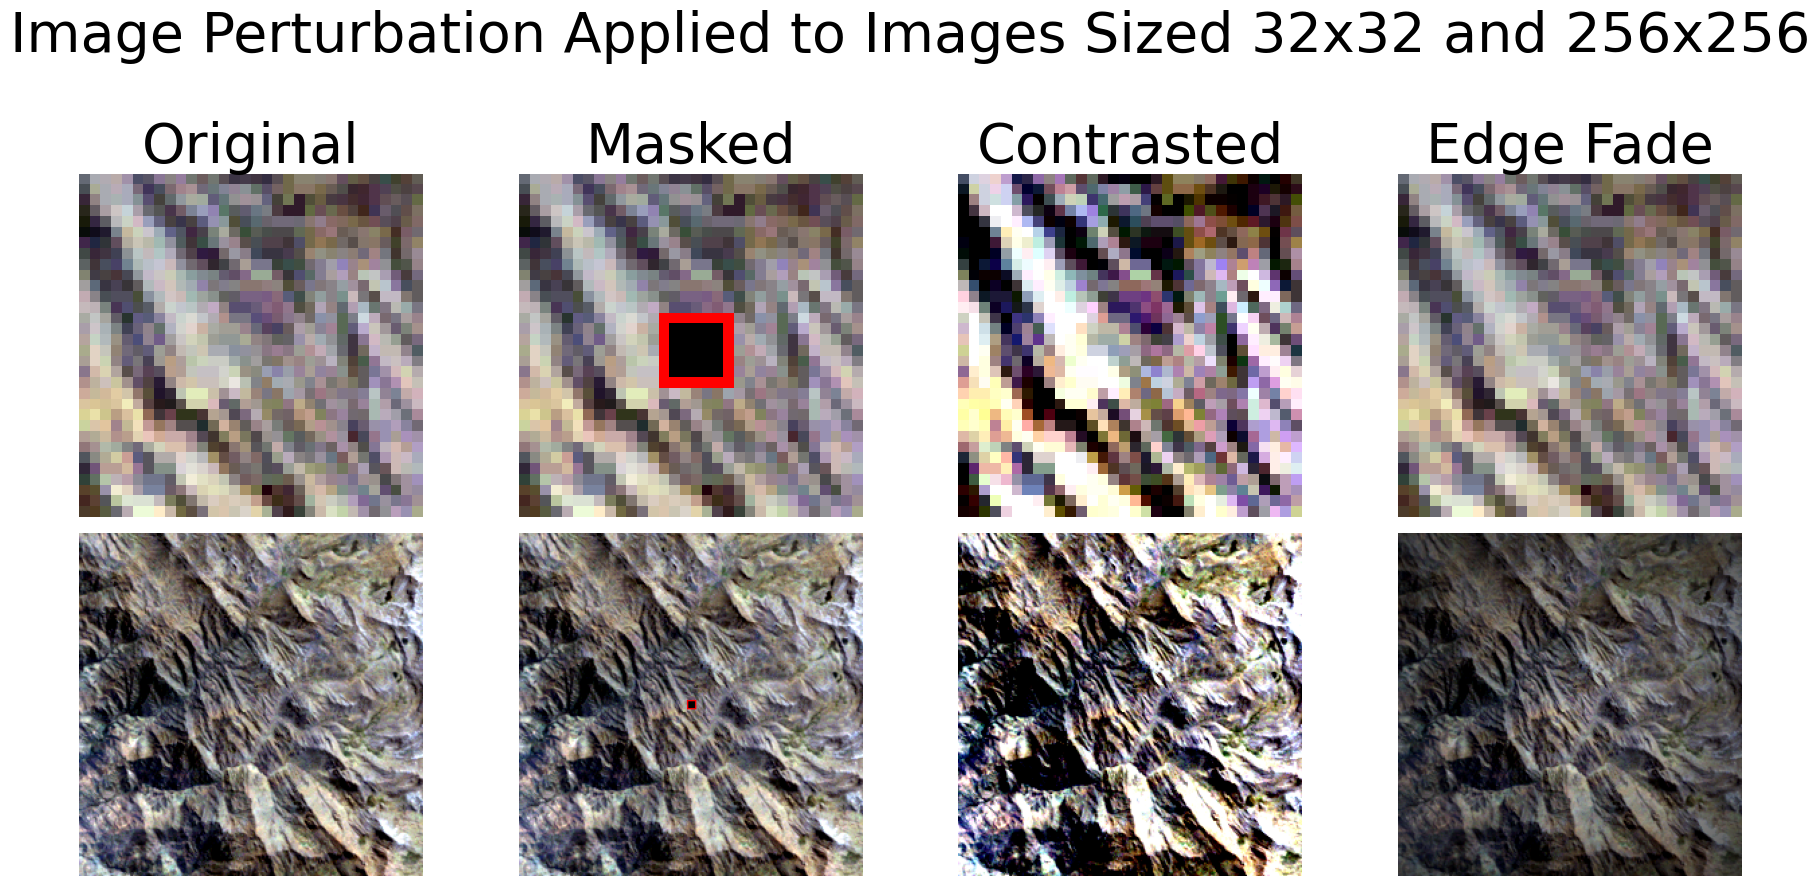

In [18]:
from PIL import ImageDraw

def add_black_blob_with_red_outline(image, blob_size=2, outline_thickness=1, outline_color=(255, 0, 0)):
    # Get the center of the image
    width, height = image.size
    center_x, center_y = width // 2, height // 2

    # Calculate the coordinates for the black rectangle (blob)
    left = center_x - blob_size // 2
    top = center_y - blob_size // 2
    right = center_x + blob_size // 2
    bottom = center_y + blob_size // 2

    # Draw the black blob
    draw = ImageDraw.Draw(image)
    draw.rectangle([left, top, right, bottom], fill=(0, 0, 0))

    # Draw the red outline around the blob (outside the black rectangle)
    draw.rectangle([left - outline_thickness, top - outline_thickness, right + outline_thickness, bottom + outline_thickness], outline=outline_color, width=outline_thickness)
    
    return image

def visualize_augmentations(pil_images_list, i, contrast_factor=2.0):
    # Pick the same image from two different sets
    image_set_0 = pil_images_list[0][i]
    image_set_1 = pil_images_list[1][i]

    # Apply augmentations on image_set_0
    original_0 = image_set_0.copy()
    blobbed_0_with_red_outline = add_black_blob_with_red_outline(original_0.copy(), blob_size=5)
    contrasted_0 = adjust_contrast(original_0, contrast_factor=contrast_factor)
    # Edge fade removed from row 1

    # Apply augmentations on image_set_1
    original_1 = image_set_1.copy()
    blobbed_1_with_red_outline = add_black_blob_with_red_outline(original_1.copy(), blob_size=5)
    contrasted_1 = adjust_contrast(original_1, contrast_factor=contrast_factor)
    faded_1 = add_edge_fade(original_1.copy(), fade_color=(0, 0, 0), fade_size=0.5)

    # Create a 2-row grid: 3 images for row 1, 4 images for row 2
    fig, axes = plt.subplots(2, 4, figsize=(18, 9))

    # Row 1: Images from pil_images_list[0][i] (3 images)
    axes[0, 0].imshow(original_0)
    axes[0, 0].set_title(f'Original', fontsize=40)
    axes[0, 0].axis('off')

    axes[0, 1].imshow(blobbed_0_with_red_outline)
    axes[0, 1].set_title(f'Masked', fontsize=40)
    axes[0, 1].axis('off')

    axes[0, 2].imshow(contrasted_0)
    axes[0, 2].set_title(f'Contrasted', fontsize=40)
    axes[0, 2].axis('off')

    axes[0, 3].imshow(original_0)
    axes[0, 3].set_title(f'Edge Fade', fontsize=40)
    axes[0, 3].axis('off')

    # Row 2: Images from pil_images_list[1][i] (4 images)
    axes[1, 0].imshow(original_1)
    axes[1, 0].axis('off')

    axes[1, 1].imshow(blobbed_1_with_red_outline)
    axes[1, 1].axis('off')

    axes[1, 2].imshow(contrasted_1)
    axes[1, 2].axis('off')

    axes[1, 3].imshow(faded_1)
    axes[1, 3].axis('off')

    # Add a global title with the desired font size
    plt.suptitle("Image Perturbation Applied to Images Sized 32x32 and 256x256", fontsize=40)

    # Adjust the spacing between the rows and columns
    plt.subplots_adjust(hspace=0.5)  # Increase the space between rows

    # Adjust layout to fit the global title and images
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Save the figure
    fig.savefig("./Simulation/Augmentation_Vis.png", dpi=600)

# Example use case
visualize_augmentations(pil_images_list, 9)
